In [1]:
import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
from config import Config
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon

import utils
import visualize
from visualize import display_images
import model as modellib
from model import log
import skimage
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Root directory of the project
ROOT_DIR = '/data1/share/shiky/Mask_RCNN/data'

img_train = os.path.join(ROOT_DIR, 'train', 'images') 
img_val = os.path.join(ROOT_DIR, 'validation', 'images') 

mask_train = os.path.join(ROOT_DIR, 'train', 'masks') 
mask_val = os.path.join(ROOT_DIR, 'validation', 'masks') 


train_imglist = os.listdir(img_train)
val_imglist = os.listdir(img_val)

train_count = len(train_imglist)
val_count = len(val_imglist)
# width = 1280
# height = 800
# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

/root/anaconda3/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
class CalConfig(Config):
    """Configuration for calcifications detection project, which is derived from standard mask rcnn config class"""
    
    # Give the configuration a recognizable name
    NAME = "cal"
    
    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 1024
    IMAGE_MAX_DIM = 1024

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = ( 16, 32, 64, 128, 512)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = CalConfig()
config.display()   



Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 1
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  1024
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           cal
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING      

In [3]:
class CalDataset(utils.Dataset):
    """Create customized dataset class to load data"""
    def load_cal(self,count, data_dir, mask_dir, namelist):
        """load """
        
        #Add classes
        self.add_class("breast", 1, "calcification" )
        
        #Add images
        
        for i in range(count):
            src = namelist[i]
            
            name = src.split('_')
            full_name = '_'.join(name[0:4])
            mask_middle= full_name.split('.')[0]
            mask_name = mask_middle + '_MASK.jpg'
            mask_path = os.path.join(mask_dir, mask_name)
            
            self.add_image("breast", image_id = i, path = os.path.join(data_dir, full_name), mask_path = mask_path , full_name =full_name)
#     def load_image(self, image_id):
#         """load image from local path"""
        
#         info = self.image_info[image_id]
       
#         image = skimage.io.imread(info.path)
        
#         return image
        
    def load_mask(self, image_id):
        """load the mask image"""
        
        info = self.image_info[image_id]
        
       
        mask = skimage.io.imread(info['mask_path']).astype(bool)
        mask = mask[:,:,np.newaxis]
        # Map class names to class IDs.
        class_ids = np.array([self.class_names.index("calcification")])
        
        return mask, class_ids.astype(np.int32)
        
    def load_name(self, image_id):
        """load the image name"""
        info = self.image_info[image_id]
        
        return info['full_name']
        

In [4]:
# Training dataset
dataset = CalDataset()
dataset.load_cal(200, img_train, mask_train, train_imglist)
dataset.prepare()

print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 200
Class Count: 2
  0. BG                                                
  1. calcification                                     


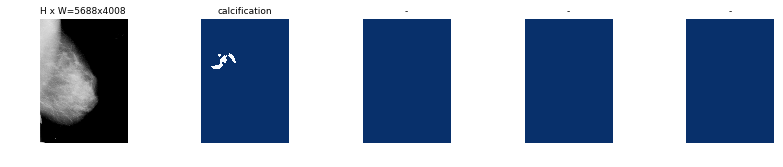

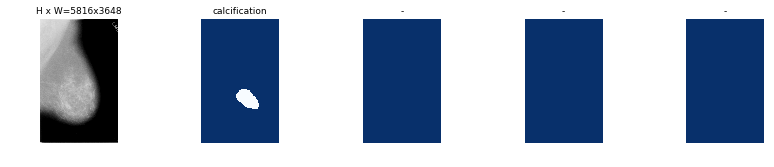

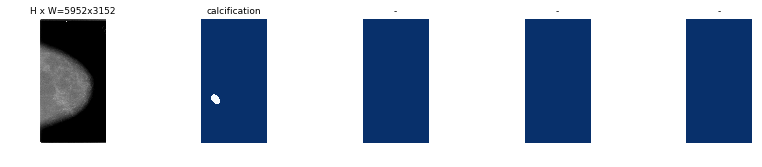

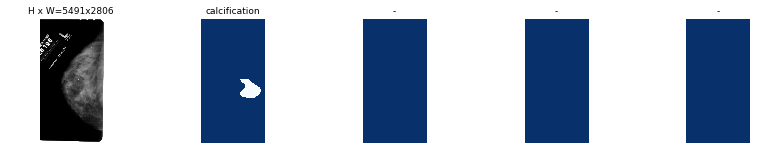

In [5]:
# Load and display random samples
image_ids = np.random.choice(dataset.image_ids, 4)
for image_id in image_ids:
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names)

image_id  53 
image                    shape: (4568, 2936, 3)       min:    0.00000  max:  255.00000
mask                     shape: (4568, 2936, 1)       min:    0.00000  max:    1.00000
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000
bbox                     shape: (1, 4)                min: 2072.00000  max: 3872.00000


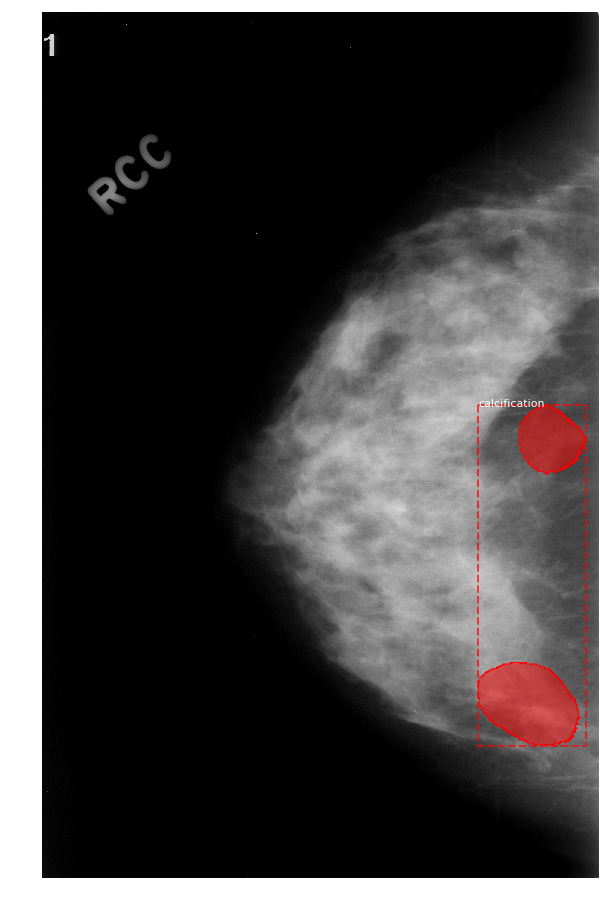

In [7]:
# Load random image and mask.
image_id = random.choice(dataset.image_ids)
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id ", image_id, dataset.image_reference(image_id))
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

/root/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


image_id:  181 
Original shape:  (5608, 4080, 3)
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000
bbox                     shape: (1, 4)                min:  141.00000  max:  227.00000


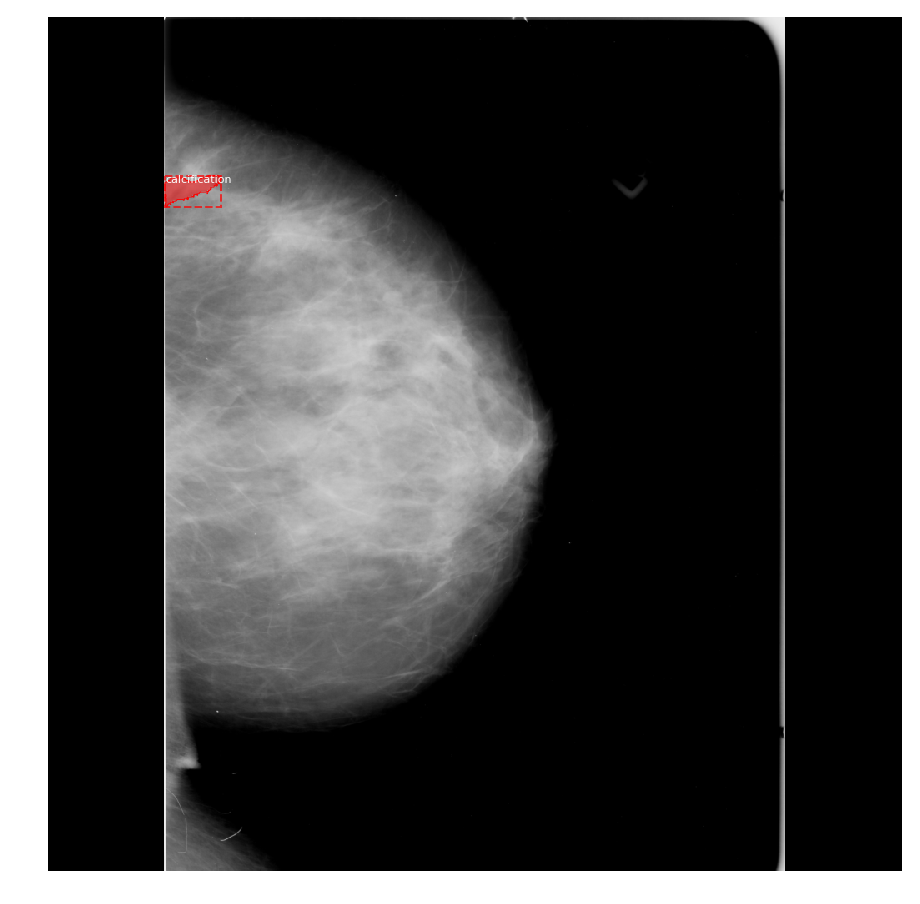

In [8]:
# Load random image and mask.
image_id = np.random.choice(dataset.image_ids, 1)[0]
image = dataset.load_image(image_id)
mask, class_ids = dataset.load_mask(image_id)
original_shape = image.shape
# Resize
image, window, scale, padding = utils.resize_image(
    image, 
    min_dim=config.IMAGE_MIN_DIM, 
    max_dim=config.IMAGE_MAX_DIM,
    padding=config.IMAGE_PADDING)
mask = utils.resize_mask(mask, scale, padding)
# Compute Bounding box
bbox = utils.extract_bboxes(mask)

# Display image and additional stats
print("image_id: ", image_id, dataset.image_reference(image_id))
print("Original shape: ", original_shape)
log("image", image)
log("mask", mask)
log("class_ids", class_ids)
log("bbox", bbox)
# Display image and instances
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000
image_meta               shape: (10,)                 min:    0.00000  max: 4568.00000
class_ids                shape: (1,)                  min:    1.00000  max:    1.00000
bbox                     shape: (1, 4)                min:  400.00000  max:  761.00000
mask                     shape: (1024, 1024, 1)       min:    0.00000  max:    1.00000


/root/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


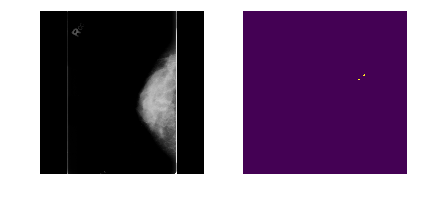

In [9]:
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, use_mini_mask=False)

log("image", image)
log("image_meta", image_meta)
log("class_ids", class_ids)
log("bbox", bbox)
log("mask", mask)

display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

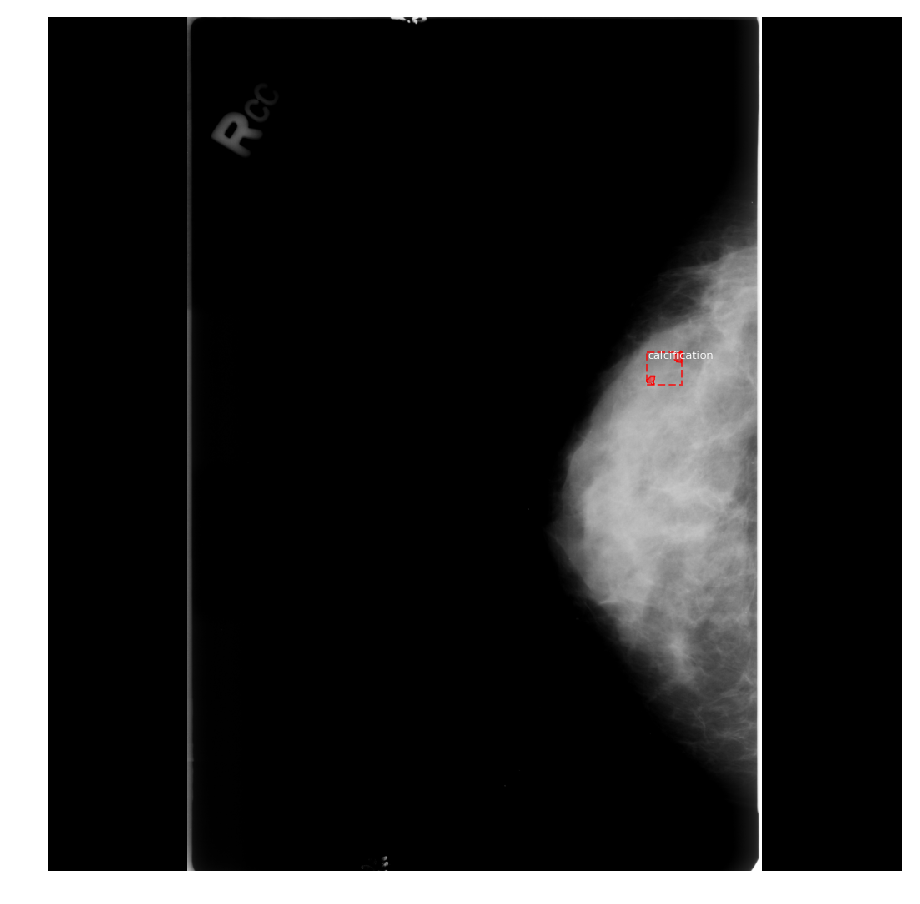

In [10]:
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

mask                     shape: (56, 56, 1)           min:    0.00000  max:    1.00000


/root/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


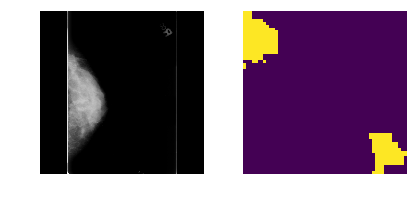

In [11]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset, config, image_id, augment=True, use_mini_mask=True)
log("mask", mask)
display_images([image]+[mask[:,:,i] for i in range(min(mask.shape[-1], 7))])

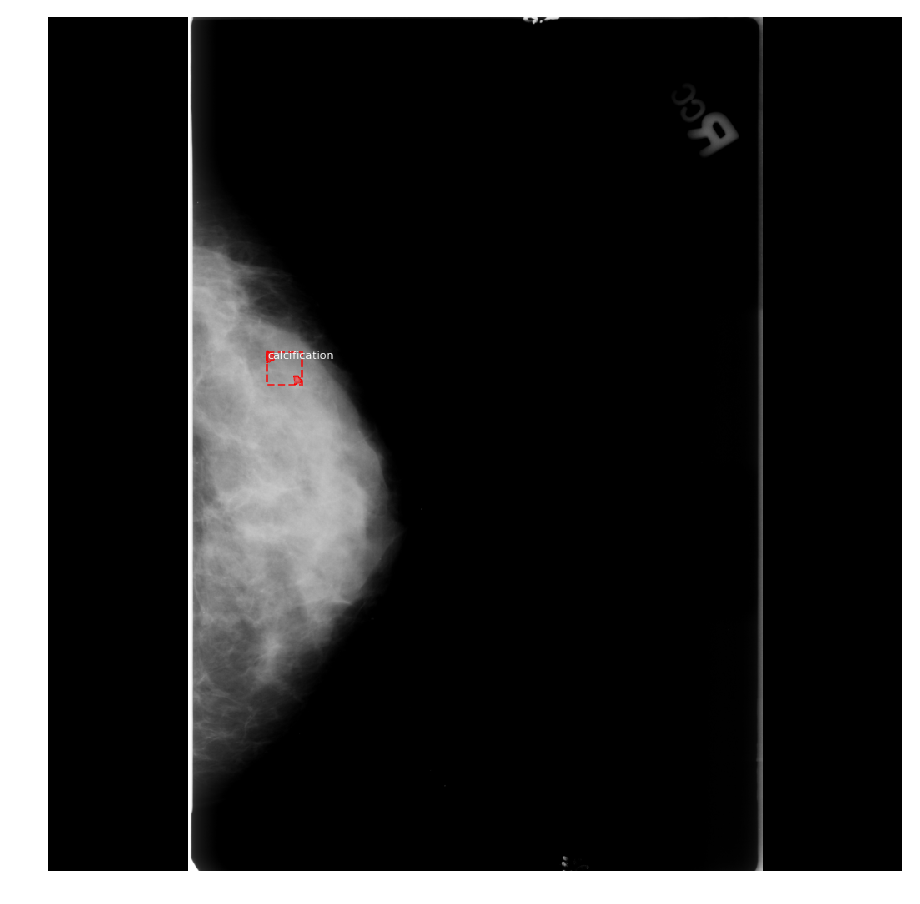

In [12]:
mask = utils.expand_mask(bbox, mask, image.shape)
visualize.display_instances(image, bbox, mask, class_ids, dataset.class_names)

In [13]:
# Generate Anchors
anchors = utils.generate_pyramid_anchors(config.RPN_ANCHOR_SCALES, 
                                          config.RPN_ANCHOR_RATIOS,
                                          config.BACKBONE_SHAPES,
                                          config.BACKBONE_STRIDES, 
                                          config.RPN_ANCHOR_STRIDE)

# Print summary of anchors
num_levels = len(config.BACKBONE_SHAPES)
anchors_per_cell = len(config.RPN_ANCHOR_RATIOS)
print("Count: ", anchors.shape[0])
print("Scales: ", config.RPN_ANCHOR_SCALES)
print("ratios: ", config.RPN_ANCHOR_RATIOS)
print("Anchors per Cell: ", anchors_per_cell)
print("Levels: ", num_levels)
anchors_per_level = []
for l in range(num_levels):
    num_cells = config.BACKBONE_SHAPES[l][0] * config.BACKBONE_SHAPES[l][1]
    anchors_per_level.append(anchors_per_cell * num_cells // config.RPN_ANCHOR_STRIDE**2)
    print("Anchors in Level {}: {}".format(l, anchors_per_level[l]))

Count:  261888
Scales:  (16, 32, 64, 128, 512)
ratios:  [0.5, 1, 2]
Anchors per Cell:  3
Levels:  5
Anchors in Level 0: 196608
Anchors in Level 1: 49152
Anchors in Level 2: 12288
Anchors in Level 3: 3072
Anchors in Level 4: 768


/root/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


Level 0. Anchors: 196608  Feature map Shape: [256 256]
Level 1. Anchors:  49152  Feature map Shape: [128 128]
Level 2. Anchors:  12288  Feature map Shape: [64 64]
Level 3. Anchors:   3072  Feature map Shape: [32 32]
Level 4. Anchors:    768  Feature map Shape: [16 16]


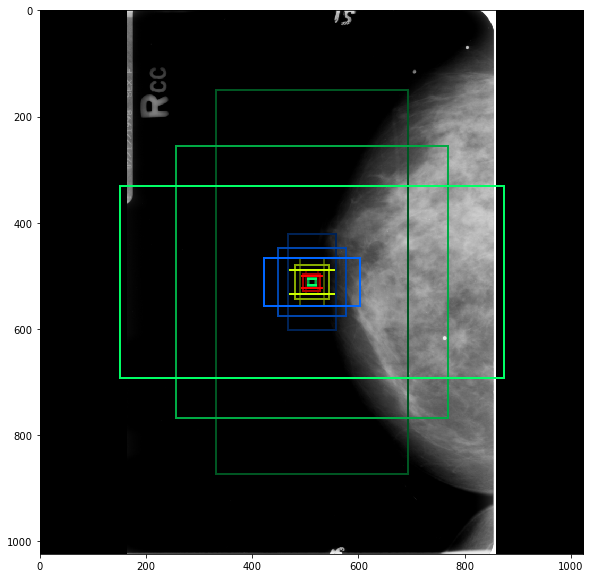

In [14]:
## Visualize anchors of one cell at the center of the feature map of a specific level

# Load and draw random image
image_id = np.random.choice(dataset.image_ids, 1)[0]
image, image_meta, _, _, _ = modellib.load_image_gt(dataset, config, image_id)
fig, ax = plt.subplots(1, figsize=(10, 10))
ax.imshow(image)
levels = len(config.BACKBONE_SHAPES)

for level in range(levels):
    colors = visualize.random_colors(levels)
    # Compute the index of the anchors at the center of the image
    level_start = sum(anchors_per_level[:level]) # sum of anchors of previous levels
    level_anchors = anchors[level_start:level_start+anchors_per_level[level]]
    print("Level {}. Anchors: {:6}  Feature map Shape: {}".format(level, level_anchors.shape[0], 
                                                                config.BACKBONE_SHAPES[level]))
    center_cell = config.BACKBONE_SHAPES[level] // 2
    center_cell_index = (center_cell[0] * config.BACKBONE_SHAPES[level][1] + center_cell[1])
    level_center = center_cell_index * anchors_per_cell 
    center_anchor = anchors_per_cell * (
        (center_cell[0] * config.BACKBONE_SHAPES[level][1] / config.RPN_ANCHOR_STRIDE**2) \
        + center_cell[1] / config.RPN_ANCHOR_STRIDE)
    level_center = int(center_anchor)

    # Draw anchors. Brightness show the order in the array, dark to bright.
    for i, rect in enumerate(level_anchors[level_center:level_center+anchors_per_cell]):
        y1, x1, y2, x2 = rect
        p = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2, facecolor='none',
                              edgecolor=(i+1)*np.array(colors[level]) / anchors_per_cell)
        ax.add_patch(p)


In [15]:
# Create data generator
random_rois = 2000
g = modellib.data_generator(
    dataset, config, shuffle=True, random_rois=random_rois, 
    batch_size=4,
    detection_targets=True)

In [20]:
# Get Next Image
if random_rois:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_class_ids, gt_boxes, gt_masks, rpn_rois, rois], \
    [mrcnn_class_ids, mrcnn_bbox, mrcnn_mask] = next(g)
    
    log("rois", rois)
    log("mrcnn_class_ids", mrcnn_class_ids)
    log("mrcnn_bbox", mrcnn_bbox)
    log("mrcnn_mask", mrcnn_mask)
else:
    [normalized_images, image_meta, rpn_match, rpn_bbox, gt_boxes, gt_masks], _ = next(g)
    
log("gt_class_ids", gt_class_ids)
log("gt_boxes", gt_boxes)
log("gt_masks", gt_masks)
log("rpn_match", rpn_match, )
log("rpn_bbox", rpn_bbox)
image_id = image_meta[0][0]
print("image_id: ", image_id, dataset.image_reference(image_id))

# Remove the last dim in mrcnn_class_ids. It's only added
# to satisfy Keras restriction on target shape.
mrcnn_class_ids = mrcnn_class_ids[:,:,0]
dataset.load_name(image_id)

rois                     shape: (4, 32, 4)            min:    6.00000  max: 1011.00000
mrcnn_class_ids          shape: (4, 32, 1)            min:    0.00000  max:    1.00000
mrcnn_bbox               shape: (4, 32, 2, 4)         min:   -2.90176  max:    3.08943
mrcnn_mask               shape: (4, 32, 28, 28, 2)    min:    0.00000  max:    1.00000
gt_class_ids             shape: (4, 100)              min:    0.00000  max:    1.00000
gt_boxes                 shape: (4, 100, 4)           min:    0.00000  max:  773.00000
gt_masks                 shape: (4, 56, 56, 100)      min:    0.00000  max:    1.00000
rpn_match                shape: (4, 261888, 1)        min:   -1.00000  max:    1.00000
rpn_bbox                 shape: (4, 256, 4)           min:   -6.43290  max:    4.13631
image_id:  171 


/root/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


'P_01336_LEFT_MLO.jpg'

anchors                  shape: (261888, 4)           min: -362.03867  max: 1322.03867
refined_anchors          shape: (1, 4)                min:  307.00006  max:  720.99994
Positive anchors: 1
Negative anchors: 255
Neutral anchors: 261632
BG                     : 22
calcification          : 10


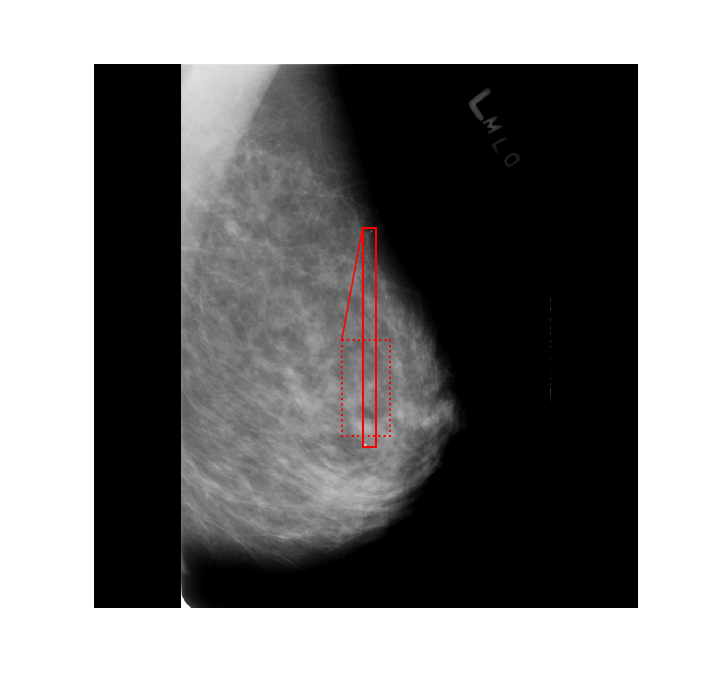

In [21]:
b = 0

# Restore original image (reverse normalization)
sample_image = modellib.unmold_image(normalized_images[b], config)

# Compute anchor shifts.
indices = np.where(rpn_match[b] == 1)[0]
refined_anchors = utils.apply_box_deltas(anchors[indices], rpn_bbox[b, :len(indices)] * config.RPN_BBOX_STD_DEV)
log("anchors", anchors)
log("refined_anchors", refined_anchors)

# Get list of positive anchors
positive_anchor_ids = np.where(rpn_match[b] == 1)[0]
print("Positive anchors: {}".format(len(positive_anchor_ids)))
negative_anchor_ids = np.where(rpn_match[b] == -1)[0]
print("Negative anchors: {}".format(len(negative_anchor_ids)))
neutral_anchor_ids = np.where(rpn_match[b] == 0)[0]
print("Neutral anchors: {}".format(len(neutral_anchor_ids)))

# ROI breakdown by class
for c, n in zip(dataset.class_names, np.bincount(mrcnn_class_ids[b].flatten())):
    if n:
        print("{:23}: {}".format(c[:20], n))

# Show positive anchors
visualize.draw_boxes(sample_image, boxes=anchors[positive_anchor_ids], 
                     refined_boxes=refined_anchors)

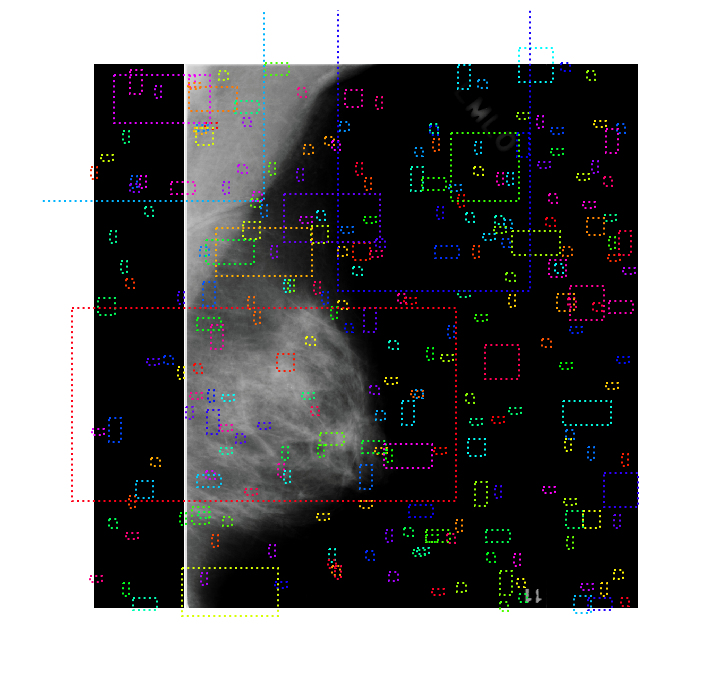

In [72]:
# Show negative anchors
visualize.draw_boxes(sample_image, boxes=anchors[negative_anchor_ids])

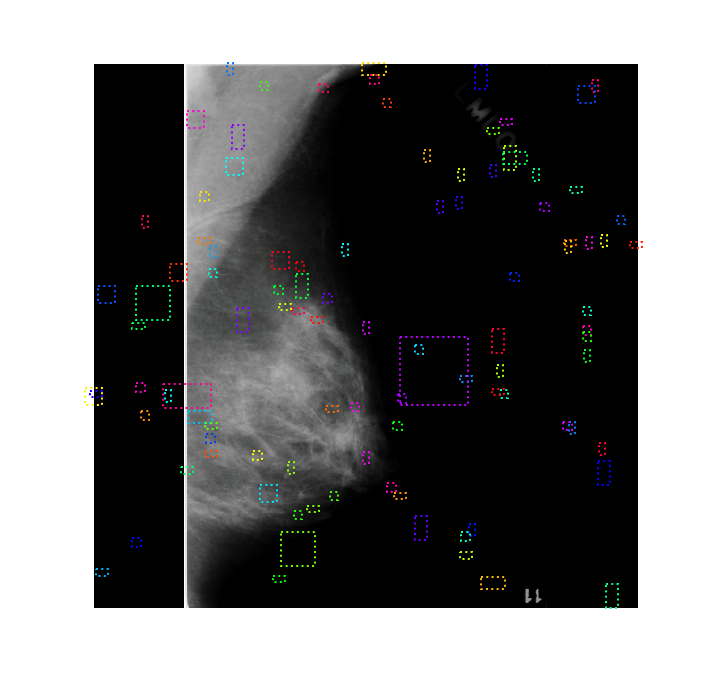

In [73]:
# Show neutral anchors. They don't contribute to training.
visualize.draw_boxes(sample_image, boxes=anchors[np.random.choice(neutral_anchor_ids, 100)])

## ROIS

Positive ROIs:  10
Negative ROIs:  22
Positive Ratio: 0.31
Unique ROIs: 32 out of 32


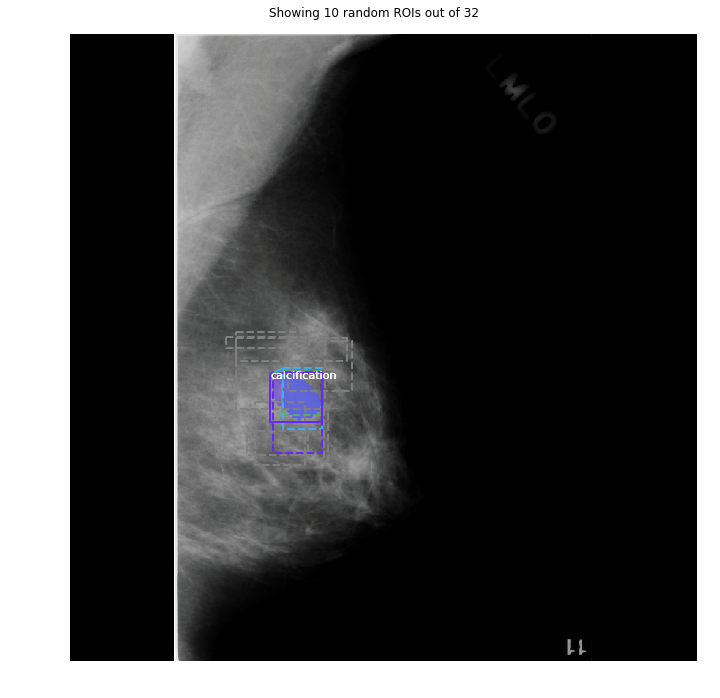

In [74]:
if random_rois:
    # Class aware bboxes
    bbox_specific = mrcnn_bbox[b, np.arange(mrcnn_bbox.shape[1]), mrcnn_class_ids[b], :]

    # Refined ROIs
    refined_rois = utils.apply_box_deltas(rois[b].astype(np.float32), bbox_specific[:,:4] * config.BBOX_STD_DEV)

    # Class aware masks
    mask_specific = mrcnn_mask[b, np.arange(mrcnn_mask.shape[1]), :, :, mrcnn_class_ids[b]]

    visualize.draw_rois(sample_image, rois[b], refined_rois, mask_specific, mrcnn_class_ids[b], dataset.class_names)
    
    # Any repeated ROIs?
    rows = np.ascontiguousarray(rois[b]).view(np.dtype((np.void, rois.dtype.itemsize * rois.shape[-1])))
    _, idx = np.unique(rows, return_index=True)
    print("Unique ROIs: {} out of {}".format(len(idx), rois.shape[1]))

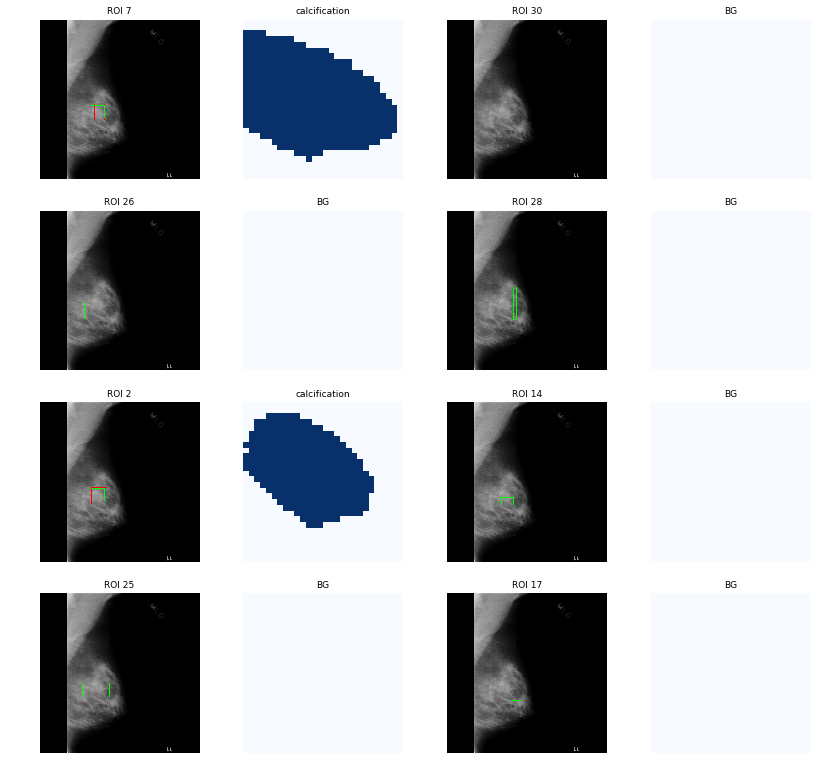

In [75]:
if random_rois:
    # Dispalay ROIs and corresponding masks and bounding boxes
    ids = random.sample(range(rois.shape[1]), 8)

    images = []
    titles = []
    for i in ids:
        image = visualize.draw_box(sample_image.copy(), rois[b,i,:4].astype(np.int32), [255, 0, 0])
        image = visualize.draw_box(image, refined_rois[i].astype(np.int64), [0, 255, 0])
        images.append(image)
        titles.append("ROI {}".format(i))
        images.append(mask_specific[i] * 255)
        titles.append(dataset.class_names[mrcnn_class_ids[b,i]][:20])

    display_images(images, titles, cols=4, cmap="Blues", interpolation="none")

In [76]:
# Check ratio of positive ROIs in a set of images.
if random_rois:
    limit = 10
    temp_g = modellib.data_generator(
        dataset, config, shuffle=True, random_rois=10000, 
        batch_size=1, detection_targets=True)
    total = 0
    for i in range(limit):
        _, [ids, _, _] = next(temp_g)
        positive_rois = np.sum(ids[0] > 0)
        total += positive_rois
        print("{:5} {:5.2f}".format(positive_rois, positive_rois/ids.shape[1]))
    print("Average percent: {:.2f}".format(total/(limit*ids.shape[1])))

/root/anaconda3/lib/python3.5/site-packages/scipy/ndimage/interpolation.py:616: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


   10  0.31
   10  0.31
   10  0.31
   10  0.31
   10  0.31
   10  0.31
   10  0.31
   10  0.31
   10  0.31
   10  0.31
Average percent: 0.31
